In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.models import Sequential
from keras.layers import Dense
from keras import models, layers
from keras.utils import plot_model
import numpy as np 
import pandas as pd
from PIL import Image
import glob
import os, os.path, shutil
from keras.preprocessing.image import img_to_array, ImageDataGenerator, array_to_img, load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import pydot
import random
from dask import bag,  diagnostics 

### Basic EDA

In [2]:
#open first image as a test 
im = Image.open('data/Blight/Corn_Blight (1).jpg')
arr = np.array(im)
arr.shape

(371, 788, 3)

In [3]:
# Directory with Blight pictures
blight_dir = os.path.join('./data/Blight')

# Directory with Common Rust pictures
rust_dir = os.path.join('./data/Common_Rust')

# Directory with Gray Leaf Spot pictures
gray_dir = os.path.join('./data/Gray_Leaf_Spot')

# Directory with Healthy pictures
healthy_dir = os.path.join('./data/Healthy')

In [4]:
train_blight_names = os.listdir(blight_dir)
print('Total Blight Images:', len(os.listdir(blight_dir)))
print(train_blight_names[:5])
print('')

train_rust_names = os.listdir(rust_dir)
print('Total Common Rust Images:', len(os.listdir(rust_dir)))
print(train_rust_names[:5])
print('')

train_gray_names = os.listdir(gray_dir)
print('Total Gray Leaf Spot Images:', len(os.listdir(gray_dir)))
print(train_gray_names[:5])
print('')

train_healthy_names = os.listdir(healthy_dir)
print('Total Healthy Images:', len(os.listdir(healthy_dir)))
print(train_healthy_names[:5])

Total Blight Images: 1146
['Corn_Blight (1).jpg', 'Corn_Blight (1146).jpg', 'Corn_Blight (1147).jpg', 'Corn_Blight (1148).jpg', 'Corn_Blight (1149).jpg']

Total Common Rust Images: 1306
['Corn_Common_Rust (1).jpg', 'Corn_Common_Rust (10).jpg', 'Corn_Common_Rust (100).JPG', 'Corn_Common_Rust (1000).JPG', 'Corn_Common_Rust (1001).JPG']

Total Gray Leaf Spot Images: 574
['Corn_Gray_Spot (1).jpg', 'Corn_Gray_Spot (10).jpg', 'Corn_Gray_Spot (100).JPG', 'Corn_Gray_Spot (101).JPG', 'Corn_Gray_Spot (102).JPG']

Total Healthy Images: 1162
['Corn_Health (1).jpg', 'Corn_Health (10).jpg', 'Corn_Health (100).jpg', 'Corn_Health (1000).jpg', 'Corn_Health (1001).jpg']


#### View sample images of each class

In [5]:
# Show images displayed 4x4
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

pic_index += 8
next_blight_pix = [os.path.join(blight_dir, fname) 
                for fname in train_blight_names[pic_index-8:pic_index]]
next_rust_pix = [os.path.join(rust_dir, fname) 
                for fname in train_rust_names[pic_index-8:pic_index]]
next_gray_pix = [os.path.join(gray_dir, fname) 
                for fname in train_gray_names[pic_index-8:pic_index]]
next_healthy_pix = [os.path.join(healthy_dir, fname) 
                for fname in train_healthy_names[pic_index-8:pic_index]]

def show_image_sample(pic_directory):
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)
    for i, img_path in enumerate(pic_directory):
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off')
        img = mpimg.imread(img_path)
        plt.imshow(img)
    plt.show()

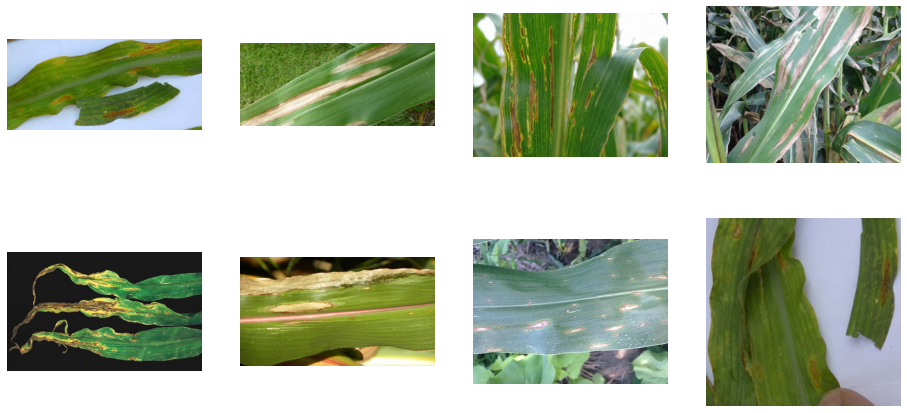

In [6]:
# Showing sample of Blight images
show_image_sample(next_blight_pix)

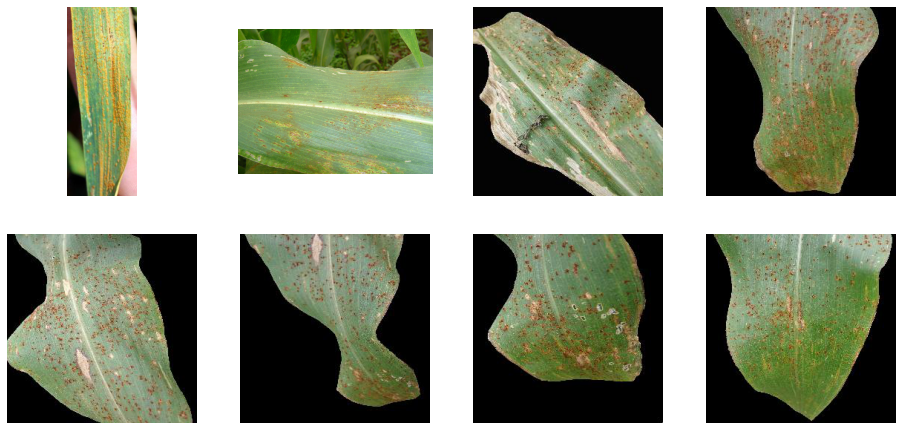

In [7]:
# Showing sample of Common Rust images
show_image_sample(next_rust_pix)

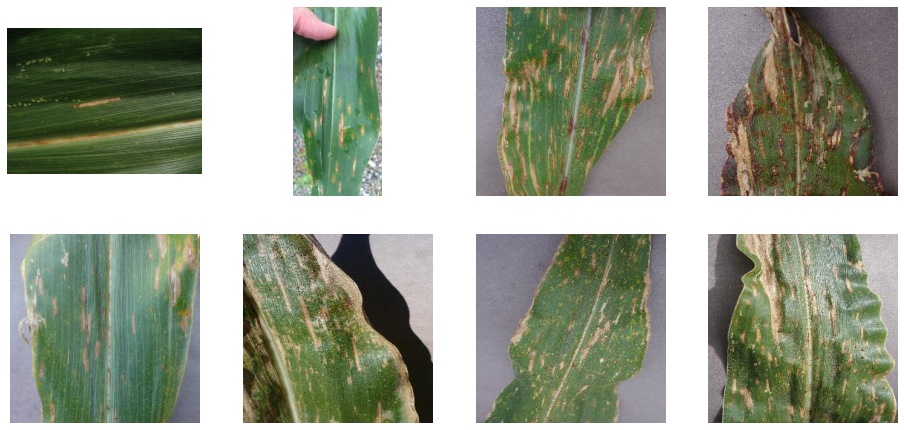

In [8]:
# Showing sample of Gray Leaf Spot images
show_image_sample(next_gray_pix)

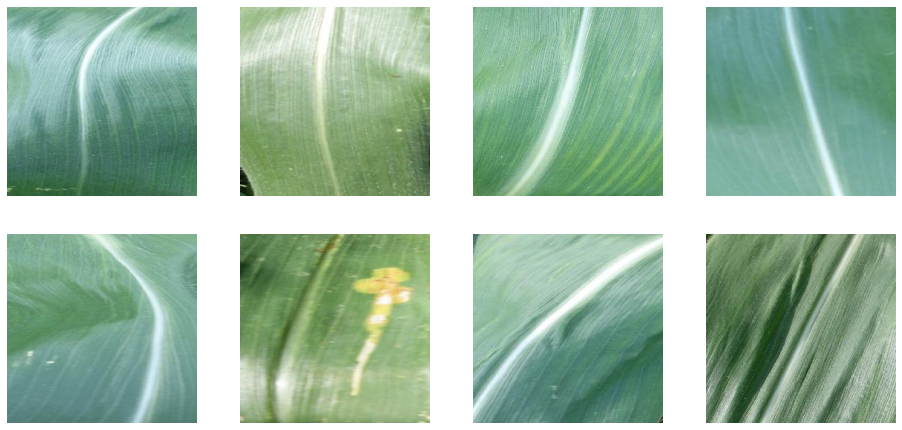

In [9]:
# Showing sample of Healthy images
show_image_sample(next_healthy_pix)

#### Visualize Image Size before Preprocessing

[########################################] | 100% Completed |  7.5s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  7.4s
[########################################] | 100% Completed |  4.9s


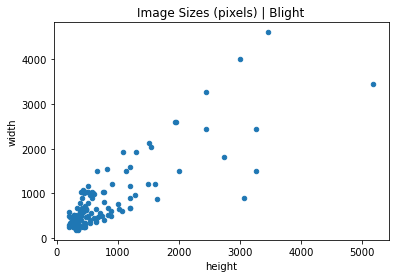

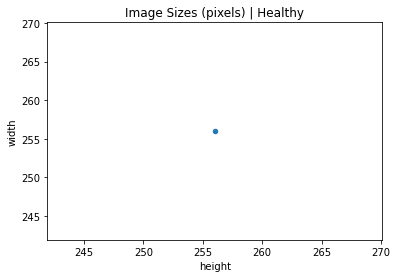

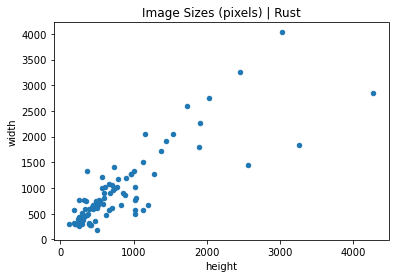

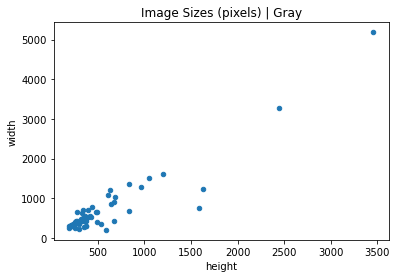

In [10]:
directories = {'Blight': 'data/Blight/',
               'Healthy': 'data/Healthy/', 
               'Rust': 'data/Common_Rust/', 
               'Gray': 'data/Gray_Leaf_Spot/'}

def get_dims(file):
    im = Image.open(file)
    arr = np.array(im)
    h,w,d = arr.shape
    return h,w

for n,d in directories.items(): 
    # parallelize
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    dimsbag = bag.from_sequence(filelist).map(get_dims)
    with diagnostics.ProgressBar():
        dims = dimsbag.compute()
        
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='height', y='width');
    plt.title('Image Sizes (pixels) | {}'.format(n))

### Splitting Images to Train/ Test Directories

In [11]:
#grab image names for each type
imgs_blight = [file for file in os.listdir(blight_dir)]
imgs_gray = [file for file in os.listdir(gray_dir)]
imgs_rust = [file for file in os.listdir(rust_dir)]
imgs_healthy = [file for file in os.listdir(healthy_dir)]

In [12]:
new_dir = 'split/'

In [13]:
#Check to ensure all images are included
print('# Blight: ', len(imgs_blight))
print('# Gray: ', len(imgs_gray))
print('# Rust: ', len(imgs_rust))
print('# Healthy: ', len(imgs_healthy))

# Blight:  1146
# Gray:  574
# Rust:  1306
# Healthy:  1162


In [14]:
#os.mkdir(new_dir)

#create variables for new split directories for train/ test
train_folder = os.path.join(new_dir, 'train')
train_blight = os.path.join(train_folder, 'blight')
train_gray = os.path.join(train_folder, 'gray')
train_rust = os.path.join(train_folder, 'rust')
train_healthy = os.path.join(train_folder, 'healthy')

test_folder = os.path.join(new_dir, 'test')
test_blight = os.path.join(test_folder, 'blight')
test_gray = os.path.join(test_folder, 'gray')
test_rust = os.path.join(test_folder, 'rust')
test_healthy = os.path.join(test_folder, 'healthy')

In [15]:
# #create directories for splits
# os.mkdir(train_folder)
# os.mkdir(train_blight)
# os.mkdir(train_gray)
# os.mkdir(train_rust)
# os.mkdir(train_healthy)

# os.mkdir(test_folder)
# os.mkdir(test_blight)
# os.mkdir(test_gray)
# os.mkdir(test_rust)
# os.mkdir(test_healthy)

In [16]:
#use a 74/13/13 split for train/ test 
print('Number of images to test:')
print('# Blight: ', round(len(imgs_blight)*.13))
print('# Gray: ', round(len(imgs_gray)*.13))
print('# Rust: ', round(len(imgs_rust)*.13))
print('# Healthy: ', round(len(imgs_healthy)*.13))

Number of images to test:
# Blight:  149
# Gray:  75
# Rust:  170
# Healthy:  151


In [17]:
# #train blight
# imgs = imgs_blight[149:]
# for img in imgs:
#     origin = os.path.join(blight_dir, img)
#     destination = os.path.join(train_blight, img)
#     shutil.copyfile(origin, destination)
    
# #train grey
# imgs = imgs_gray[75:]
# for img in imgs:
#     origin = os.path.join(gray_dir, img)
#     destination = os.path.join(train_gray, img)
#     shutil.copyfile(origin, destination)
    
# #train rust
# imgs = imgs_rust[170:]
# for img in imgs:
#     origin = os.path.join(rust_dir, img)
#     destination = os.path.join(train_rust, img)
#     shutil.copyfile(origin, destination)
    
# #train healthy
# imgs = imgs_healthy[151:]
# for img in imgs:
#     origin = os.path.join(healthy_dir, img)
#     destination = os.path.join(train_healthy, img)
#     shutil.copyfile(origin, destination)

In [18]:
# # test blight
# imgs = imgs_blight[:149]
# for img in imgs:
#     origin = os.path.join(blight_dir, img)
#     destination = os.path.join(test_blight, img)
#     shutil.copyfile(origin, destination)
    
# # test grey
# imgs = imgs_gray[:75]
# for img in imgs:
#     origin = os.path.join(gray_dir, img)
#     destination = os.path.join(test_gray, img)
#     shutil.copyfile(origin, destination)
    
# # test rust
# imgs = imgs_rust[:170]
# for img in imgs:
#     origin = os.path.join(rust_dir, img)
#     destination = os.path.join(test_rust, img)
#     shutil.copyfile(origin, destination)
    
# # test healthy
# imgs = imgs_healthy[:151]
# for img in imgs:
#     origin = os.path.join(healthy_dir, img)
#     destination = os.path.join(test_healthy, img)
#     shutil.copyfile(origin, destination)

In [20]:
classes = ['blight','rust','gray','healthy']
num_epochs = 30
batch_size = 32

In [21]:
# Rescaling images by 1./255
# Splitting data into training and test sets
train_datagen = ImageDataGenerator(rescale = 1/255,
                                  validation_split = 0.2)

# Flow training images in batches
train_generator = train_datagen.flow_from_directory(
        './split/train',
        target_size=(200, 200),
        batch_size=batch_size,
        classes = classes,
        class_mode='categorical',
        subset='training')

# Flow validation images in batches
validation_generator = train_datagen.flow_from_directory(
        './split/train',
        target_size=(200, 200),
        batch_size=batch_size,
        classes = classes,
        class_mode='categorical',
        subset='validation')

Found 2916 images belonging to 4 classes.
Found 727 images belonging to 4 classes.


In [22]:
#create images/ labels
train_images, train_labels = next(train_generator)

In [23]:
# #reshape all images
# test_batch = 545
# val_batch = 544
# train_batch = 3099

# # get all test images and reshape 
# test_generator = ImageDataGenerator(rescale=1/255).flow_from_directory(test_folder, target_size=(200, 200),
#                                                                         batch_size = batch_size,
#                                                                         classes = classes)

# # get all validation images and reshape 
# val_generator = ImageDataGenerator(rescale=1/255).flow_from_directory(val_folder, target_size=(200, 200), 
#                                                                       batch_size = batch_size,
#                                                                       classes = classes)

# # get all train images and reshape 
# train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_folder, target_size=(200, 200),
#                                                                         batch_size = batch_size,
#                                                                         classes = classes)


# #create images/ labels
# train_images, train_labels = next(train_generator)
# test_images, test_labels = next(test_generator)
# val_images, val_labels = next(val_generator)

In [24]:
train_images.shape[0]

32

In [97]:
# train_img = train_images.reshape(train_images.shape[0], -1)
# test_img = test_images.reshape(test_images.shape[0], -1)
# val_img = val_images.reshape(val_images.shape[0], -1)

# #double check shape to make sure all the images are included
# print(train_img.shape)
# print(test_img.shape)
# print(val_img.shape)

In [98]:
##create labels for all three splits
#train_y = np.reshape(train_labels[:,0], (3099,1))

### Modeling with CNN's

#### Baseline Model: CNN with a Single Convolutional Layer & Softmax Output

In [31]:
classes = ['blight','rust','gray','healthy']
num_epochs = 30
batch_size = 32

# Training sample count
training_sample=train_generator.n 
    
# Validation sample count
val_sample=validation_generator.n

In [26]:
training_sample

2916

In [34]:
#first CNN with 2 convolutional layers

input_shape = (64, 64, 3)
x = tf.random.normal(input_shape)
    
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (5,5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

#Compiling with Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(lr=.003),
                loss="categorical_crossentropy",
                metrics='accuracy')

In [35]:
history_cnn = model.fit(train_generator,
                    epochs=30,
                    batch_size=batch_size,
                    steps_per_epoch=int((training_sample//batch_size)-1),
                    validation_data= validation_generator)

Epoch 1/30
90/90 [==============================] - 146s 2s/step - loss: 1.2952 - accuracy: 0.5435 - val_loss: 1.0233 - val_accuracy: 0.5172
Epoch 2/30
90/90 [==============================] - 147s 2s/step - loss: 0.8594 - accuracy: 0.5631 - val_loss: 1.0837 - val_accuracy: 0.5227
Epoch 3/30
90/90 [==============================] - 149s 2s/step - loss: 0.8282 - accuracy: 0.5687 - val_loss: 1.1042 - val_accuracy: 0.5227
Epoch 4/30
90/90 [==============================] - 145s 2s/step - loss: 0.8195 - accuracy: 0.5582 - val_loss: 1.0849 - val_accuracy: 0.5199
Epoch 5/30
90/90 [==============================] - 147s 2s/step - loss: 1.0256 - accuracy: 0.5533 - val_loss: 1.0639 - val_accuracy: 0.5186
Epoch 6/30
90/90 [==============================] - 141s 2s/step - loss: 0.8780 - accuracy: 0.5614 - val_loss: 1.0444 - val_accuracy: 0.5172
Epoch 7/30
90/90 [==============================] - 145s 2s/step - loss: 0.8171 - accuracy: 0.5600 - val_loss: 1.0564 - val_accuracy: 0.5241
Epoch 8/30
90

In [ ]:
def viz_train_res(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

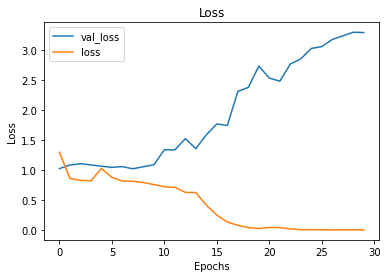

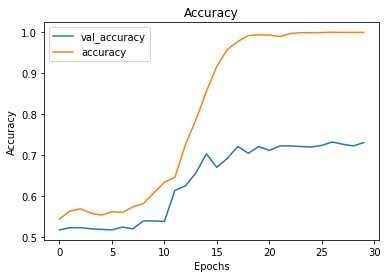

In [36]:
viz_train_res(history_cnn)

This model is overfitting the training data and not performing as well on the validation set. The following models will focus on improving validation performance. 

In [27]:
#CNN with a single convolutional layer to combat overfitting

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    # 4 output neurons for 4 classes
    tf.keras.layers.Dense(4, activation='softmax')
])

In [28]:
# Compiling with RMSprop optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

In [29]:
# Training model
history_cnn2 = model.fit(train_generator,
    steps_per_epoch=int((training_sample//batch_size)-1),
    validation_data = (validation_generator),
    validation_steps = int((val_sample//batch_size)-1),
    epochs=num_epochs,
    verbose=1)

Epoch 1/30
90/90 [==============================] - 58s 649ms/step - loss: 8.2105 - accuracy: 0.6059 - val_loss: 1.4920 - val_accuracy: 0.6533
Epoch 2/30
90/90 [==============================] - 57s 633ms/step - loss: 0.4700 - accuracy: 0.8278 - val_loss: 0.5843 - val_accuracy: 0.7738
Epoch 3/30
90/90 [==============================] - 55s 613ms/step - loss: 0.3231 - accuracy: 0.8787 - val_loss: 0.5232 - val_accuracy: 0.7991
Epoch 4/30
90/90 [==============================] - 56s 620ms/step - loss: 0.2138 - accuracy: 0.9313 - val_loss: 0.6055 - val_accuracy: 0.8021
Epoch 5/30
90/90 [==============================] - 56s 618ms/step - loss: 0.1458 - accuracy: 0.9541 - val_loss: 0.6106 - val_accuracy: 0.8259
Epoch 6/30
90/90 [==============================] - 55s 614ms/step - loss: 0.1090 - accuracy: 0.9727 - val_loss: 0.5798 - val_accuracy: 0.8408
Epoch 7/30
90/90 [==============================] - 56s 625ms/step - loss: 0.0870 - accuracy: 0.9818 - val_loss: 0.5864 - val_accuracy: 0.8452

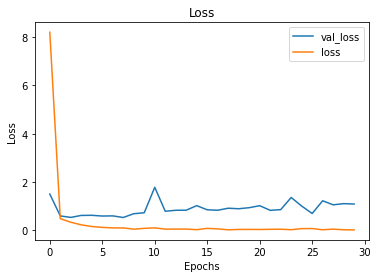

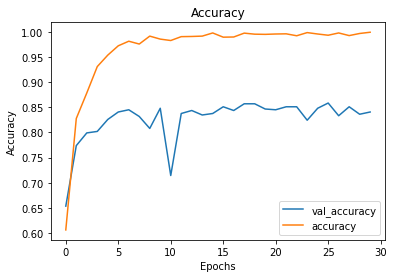

In [33]:
viz_train_res(history_cnn2)

Reducing the number of layers solved for some of the overfitting, but more work needs to be done.

#### Reloading Images and Applying Data Augmentation

One way to combat overfitting in image classification is with data augmentation. This process takes an image and changes it in various ways so that the model learns to differentiate to images in many different formats and appearances.

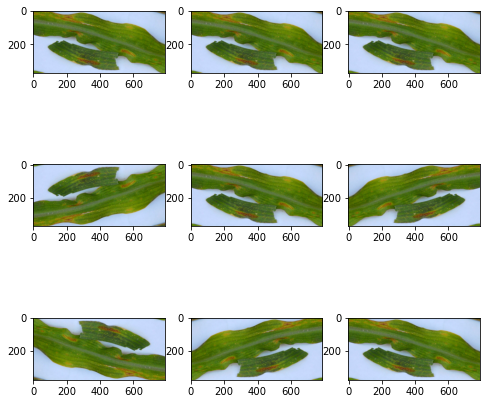

In [37]:
# Blight leaf image
img = load_img('data/Blight/Corn_Blight (1).jpg')
data = img_to_array(img)
samples = np.expand_dims(data, 0)
# Demonstrating horizontal and vertical flips
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
it = datagen.flow(samples, batch_size=1)

# Generate samples and plot
fig=plt.gcf()
fig.set_size_inches(ncols * 2, nrows * 2)
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

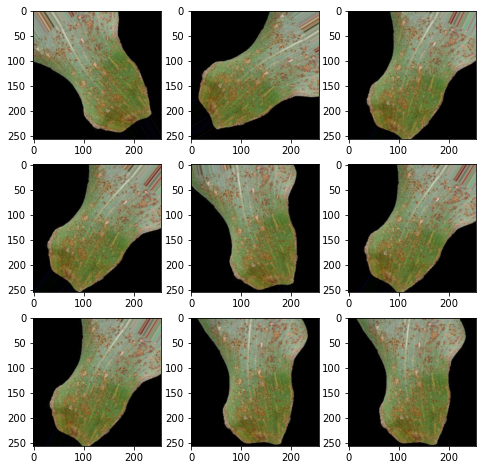

In [38]:
# Data augmentation example
# Common Rust leaf image
img = load_img('./data/Common_Rust/Corn_Common_Rust (1000).JPG')
data = img_to_array(img)
samples = np.expand_dims(data, 0)
# Demonstrating random rotation
datagen = ImageDataGenerator(rotation_range=90, fill_mode='nearest')
it = datagen.flow(samples, batch_size=1)

# Generate samples and plot
fig=plt.gcf()
fig.set_size_inches(ncols * 2, nrows * 2)
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

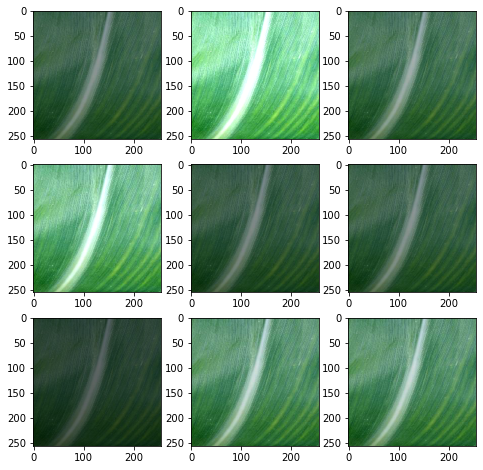

In [39]:
# Healthy leaf image
img = load_img('./data/Healthy/Corn_Health (100).jpg')
data = img_to_array(img)
samples = np.expand_dims(data, 0)
# Demonstrating brightness augmentation
datagen = ImageDataGenerator(brightness_range=[0.4,1.5])
it = datagen.flow(samples, batch_size=1)

# Generate samples and plot
fig=plt.gcf()
fig.set_size_inches(ncols * 2, nrows * 2)
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

To ensure that our model can generalize to the validation data and not overfit to the training data, we will be randomly augmenting the training images using the methods shown above.

In [40]:
# Rescaling images by 1./255
# Splitting data into training and validation sets
# Performing data augmentation on training images
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   rotation_range=90, fill_mode='nearest',
                                   brightness_range=[0.4,1.5],
                                   validation_split = 0.2)

# Flow training images in batches
train_generator = train_datagen.flow_from_directory(
        './split/train',
        target_size=(200, 200),
        batch_size=batch_size,
        classes = classes,
        class_mode='categorical',
        subset='training')

# Flow validation images in batches
validation_generator = train_datagen.flow_from_directory(
        './split/train',
        target_size=(200, 200),
        batch_size=batch_size,
        classes = classes,
        class_mode='categorical',
        subset='validation')

Found 2916 images belonging to 4 classes.
Found 727 images belonging to 4 classes.


#### Next CNNs using Data Augmentation & Adam Optimizer

In [41]:
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    # 4 output neurons for 4 classes
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compiling with adam optimizer
model_3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
    
# Training
history_cnn3 = model_3.fit(
        train_generator, 
        steps_per_epoch=int(training_sample/batch_size),
        validation_data = validation_generator,
        validation_steps = int(val_sample/batch_size),
        epochs=num_epochs,
        verbose=1)

Epoch 1/30
91/91 [==============================] - 139s 2s/step - loss: 2.1959 - acc: 0.6886 - val_loss: 0.5028 - val_acc: 0.8196
Epoch 2/30
91/91 [==============================] - 131s 1s/step - loss: 0.4366 - acc: 0.8284 - val_loss: 0.5882 - val_acc: 0.7656
Epoch 3/30
91/91 [==============================] - 132s 1s/step - loss: 0.4441 - acc: 0.8298 - val_loss: 0.4784 - val_acc: 0.8182
Epoch 4/30
91/91 [==============================] - 127s 1s/step - loss: 0.3780 - acc: 0.8561 - val_loss: 0.5598 - val_acc: 0.8125
Epoch 5/30
91/91 [==============================] - 123s 1s/step - loss: 0.3767 - acc: 0.8474 - val_loss: 0.4553 - val_acc: 0.8338
Epoch 6/30
91/91 [==============================] - 131s 1s/step - loss: 0.3492 - acc: 0.8530 - val_loss: 0.4284 - val_acc: 0.8338
Epoch 7/30
91/91 [==============================] - 125s 1s/step - loss: 0.3305 - acc: 0.8648 - val_loss: 0.4675 - val_acc: 0.8253
Epoch 8/30
91/91 [==============================] - 122s 1s/step - loss: 0.3145 - a

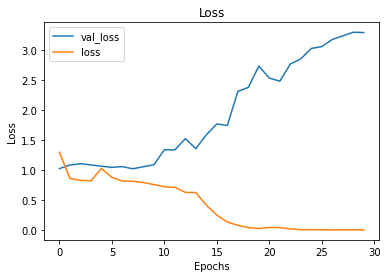

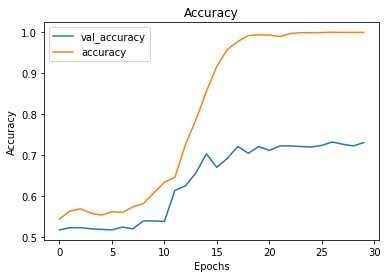

In [42]:
viz_train_res(history_cnn2)

Although data augmentation has helped, overfitting is still happening, we can see it gets much worse around epoch 15. 

#### CNN With Data Augmentation & Dropout Layer

Dropout layers are another way of combatting overfitting issues. One dropout layer will be added after the last convolutional layer and before the dense layer and output. 

In [43]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (5,5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate = .5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(lr=.003),
                loss="sparse_categorical_crossentropy",
                metrics='accuracy')

In [44]:
# Compiling with adam optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
# Training
history_cnn4 = model.fit(
        train_generator, 
        steps_per_epoch=int(training_sample/batch_size),
        validation_data = validation_generator,
        validation_steps = int(val_sample/batch_size),
        epochs=num_epochs,
        verbose=1)

Epoch 1/30
91/91 [==============================] - 134s 1s/step - loss: 1.1552 - accuracy: 0.5520 - val_loss: 1.0677 - val_accuracy: 0.5156
Epoch 2/30
91/91 [==============================] - 133s 1s/step - loss: 0.7202 - accuracy: 0.7788 - val_loss: 0.9068 - val_accuracy: 0.7585
Epoch 3/30
91/91 [==============================] - 132s 1s/step - loss: 0.5349 - accuracy: 0.8117 - val_loss: 0.5724 - val_accuracy: 0.7997
Epoch 4/30
91/91 [==============================] - 129s 1s/step - loss: 0.4577 - accuracy: 0.8332 - val_loss: 0.5637 - val_accuracy: 0.7898
Epoch 5/30
91/91 [==============================] - 129s 1s/step - loss: 0.3925 - accuracy: 0.8440 - val_loss: 0.4988 - val_accuracy: 0.8125
Epoch 6/30
91/91 [==============================] - 133s 1s/step - loss: 0.3732 - accuracy: 0.8422 - val_loss: 0.4679 - val_accuracy: 0.8239
Epoch 7/30
91/91 [==============================] - 132s 1s/step - loss: 0.3745 - accuracy: 0.8485 - val_loss: 0.4553 - val_accuracy: 0.8168
Epoch 8/30
91

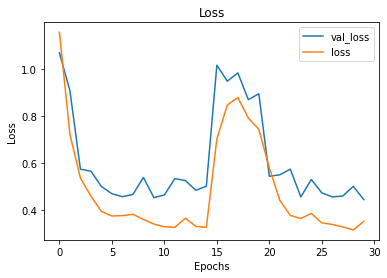

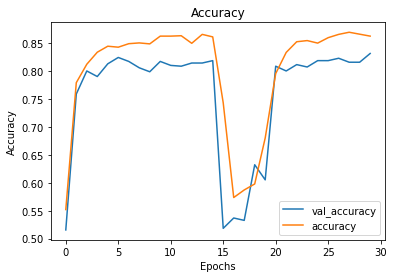

In [45]:
viz_train_res(history_cnn4)

In [46]:
#adjusting the axis of the above plots

def viz_train_res2(results):
    history = results.history
    plt.figure()
    plt.axis(ymax = 1)
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.axis(ymin = 0)
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

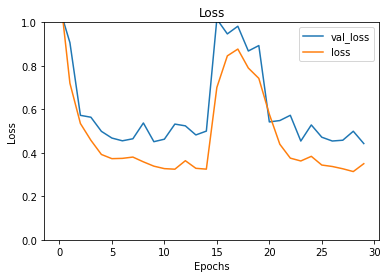

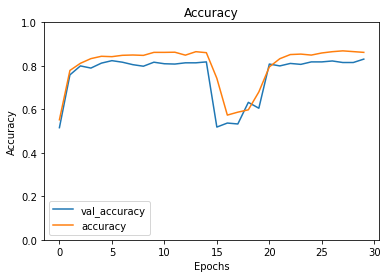

In [47]:
viz_train_res2(history_cnn4)

Adding this dropout layer seemed to solve for a lot of overfitting, however accuracy has gone down and there's concern about the dip in accuracy around epoch 15. 

This model has 2 convolutional layers, the next model will drop one of those layers in the hopes of solving for this dip and raising the overall accuracy while maintaining a lower level of overfitting. 

In [48]:
#removing a convolutional layer and keeping the dropout layer
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate = .5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(lr=.003),
                loss="sparse_categorical_crossentropy",
                metrics='accuracy')

In [50]:
# Compiling with adam optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
# Training
history_cnn5 = model.fit(
        train_generator, 
        steps_per_epoch=int(training_sample/batch_size),
        validation_data = validation_generator,
        validation_steps = int(val_sample/batch_size),
        epochs=num_epochs,
        verbose=1)

Epoch 1/30
91/91 [==============================] - 143s 2s/step - loss: 0.7652 - accuracy: 0.7604 - val_loss: 0.5198 - val_accuracy: 0.8026
Epoch 2/30
91/91 [==============================] - 142s 2s/step - loss: 0.3987 - accuracy: 0.8440 - val_loss: 0.4648 - val_accuracy: 0.8068
Epoch 3/30
91/91 [==============================] - 141s 2s/step - loss: 0.3825 - accuracy: 0.8530 - val_loss: 0.6206 - val_accuracy: 0.7997
Epoch 4/30
91/91 [==============================] - 143s 2s/step - loss: 0.3274 - accuracy: 0.8707 - val_loss: 0.5016 - val_accuracy: 0.8026
Epoch 5/30
91/91 [==============================] - 141s 2s/step - loss: 0.3269 - accuracy: 0.8644 - val_loss: 0.4740 - val_accuracy: 0.8310
Epoch 6/30
91/91 [==============================] - 143s 2s/step - loss: 0.3030 - accuracy: 0.8669 - val_loss: 0.4509 - val_accuracy: 0.7997
Epoch 7/30
91/91 [==============================] - 143s 2s/step - loss: 0.3248 - accuracy: 0.8603 - val_loss: 0.3493 - val_accuracy: 0.8622
Epoch 8/30
91

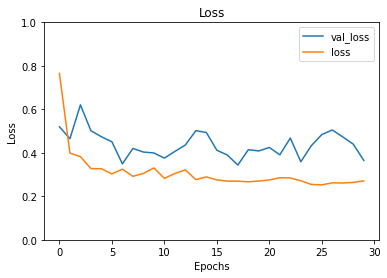

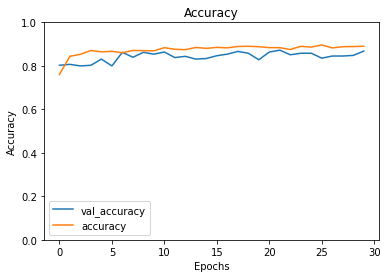

In [51]:
viz_train_res2(history_cnn5)